## Cognitive Battery Introduction: Jax-3DP3

In [4]:
import os
import numpy as np
import jax3dp3
from jax3dp3.viz import (
    get_depth_image,
    multi_panel,
)
from jax3dp3.transforms_3d import transform_from_pos, unproject_depth
import jax.numpy as jnp
import jax
from jax3dp3.viz import make_gif_from_pil_images
from PIL import Image
from tqdm import tqdm

import cog_utils as utils

In [5]:
scene = "gravity"
data_path = f"/home/khaledshehada/cog_jax3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [7]:
width = 300
height = 300
fov = 90

fx, fy, cx, cy = utils.get_camera_intrinsics(width, height, fov)
near, far = 0.001, 50.0

intrinsics = jax3dp3.Intrinsics(height, width, fx, fy, cx, cy, near, far)
renderer = jax3dp3.Renderer(intrinsics=intrinsics)

Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [8]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    if not os.path.isfile(rgb_path):
        rgb_path = rgb_path.replace("jpeg", "png")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

In [11]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in range(num_frames):
    coord_image = unproject_depth(depth_images[frame_idx], intrinsics)
    segmentation_image = seg_maps[frame_idx].copy()
    mask = np.invert(
        (coord_image[:, :, 0] < 1.1)
        * (coord_image[:, :, 0] > -1)
        * (coord_image[:, :, 1] < 0.565)
        * (coord_image[:, :, 1] > -1)
        * (coord_image[:, :, 2] > 1.2)
        * (coord_image[:, :, 2] < 1.35)
    )
    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

In [13]:
# Load meshes
meshes = []
meshes_path = "/home/khaledshehada/cog_jax3dp3_data/gravity_data/meshes/"
for mesh_name in os.listdir(meshes_path):
    mesh_path = os.path.join(meshes_path, mesh_name)
    renderer.add_mesh_from_file(mesh_path, force="mesh")
    meshes.append(mesh_name.replace(".obj", ""))
    print(meshes[-1])

apple
tube_s_long
bowl
tube_s


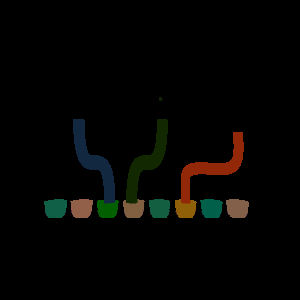

In [14]:
start_t = 36
seg_img = seg_images[start_t]
Image.fromarray(seg_img)

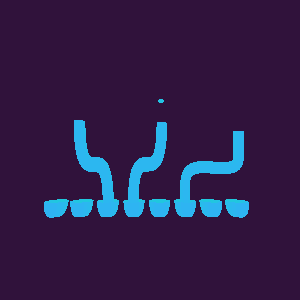

In [15]:
num_objects = 12
indices, init_poses = [], []
obj_ids = jnp.unique(seg_img.reshape(-1, 3), axis=0)
obj_ids = sorted(
    obj_ids, key=lambda x: jnp.all(seg_img == x, axis=-1).sum(), reverse=True
)
for obj_id in obj_ids[: num_objects + 1]:
    if jnp.all(obj_id == 0):
        # Background
        continue

    obj_mask = jnp.all(seg_img == obj_id, axis=-1)
    masked_depth = coord_images[start_t].copy()
    masked_depth[~obj_mask] = 0

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    obj_center = (maxs + mins) / 2
    obj_transform = transform_from_pos(obj_center)

    best = None
    k = np.inf
    for m in range(len(meshes)):
        obj_transforms = utils.get_object_transforms(meshes[m], obj_transform)
        for i, transform in enumerate(obj_transforms):
            rendered_image = renderer.render_single_object(transform, m)
            keep_points = (
                jnp.sum(
                    jnp.logical_or(
                        (
                            (masked_depth[:, :, 2] != 0.0)
                            * (rendered_image[:, :, 2] == 0)
                        ),
                        (
                            (masked_depth[:, :, 2] == 0.0)
                            * (rendered_image[:, :, 2] != 0)
                        ),
                    )
                )
                / (rendered_image[:, :, 2] != 0.0).sum()
            )
            if keep_points < k:
                k = keep_points
                best = (m, transform)
    if best:
        indices.append(best[0])
        init_poses.append(best[1])

init_poses = jnp.array(init_poses)
rendered_image = renderer.render_multiobject(init_poses, indices)
get_depth_image(rendered_image[:, :, 2], max=5)

In [16]:
# Liklihood parameters
r = radius = 0.1
outlier_prob = 0.01
outlier_volume = 10

# Enumeration parameters
n = 7  # number of enumerated proposals on each dimension (x, y, z).
d = 0.05  # the minimum and maximum position delta on each dimension (x, y, z).

# Enumerating proposals
translation_deltas = jax3dp3.make_translation_grid_enumeration(
    -d, -d, -d, d, d, d, n, n, n
)


def scorer(rendered_image, gt, prior):
    weight = jax3dp3.likelihood.threedp3_likelihood(
        gt, rendered_image, r, outlier_prob, outlier_volume
    )
    return prior * weight


scorer_parallel = jax.vmap(scorer, in_axes=(0, None, 0))
scorer_parallel_jit = jax.jit(scorer_parallel)

In [17]:
# Idea for liklihood model under occlusion:
pose_estimates = init_poses.copy()
t = start_t
gt_image = jnp.array(coord_images[t])

translation_deltas_full = jnp.tile(
    jnp.eye(4)[None, :, :],
    (translation_deltas.shape[0], pose_estimates.shape[0], 1, 1),
)
translation_deltas_full = translation_deltas_full.at[:, 0, :, :].set(translation_deltas)
translation_proposals = jnp.einsum(
    "bij,abjk->abik", pose_estimates, translation_deltas_full
)
images = renderer.render_parallel(translation_proposals, 0)
prior = jnp.ones((translation_deltas.shape[0],))
weights_new = scorer_parallel_jit(images, gt_image, prior)
pose_estimates = translation_proposals[jnp.argmax(weights_new)]

In [19]:
num_steps = num_frames - start_t
num_steps = 10
inferred_poses = []
occlusion_threshold = 10
pose_estimates = init_poses.copy()
# tqdm = lambda x: x
# occluded = False
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])
    # New objects
    n_objects = pose_estimates.shape[0]
    for i in range(n_objects):
        # Check for occlusion
        depth_wi = renderer.render_multiobject(pose_estimates, indices)
        depth_woi = renderer.render_multiobject(pose_estimates[:i], indices[:i])
        if jnp.sum(depth_wi[:, :, 2] != depth_woi[:, :, 2]) < occlusion_threshold:
            # prior = (1 - translation_deltas[:,1,3]) * abs(translation_deltas[:,0,3]) * abs(translation_deltas[:,2,3])
            prior = (1 - translation_deltas[:, 1, 3]) * abs(translation_deltas[:, 2, 3])
        else:
            prior = jnp.ones((translation_deltas.shape[0],))

        pose_estimate = pose_estimates[i]
        translation_proposals = jnp.einsum(
            "ij,ajk->aik", pose_estimate, translation_deltas
        )
        images = renderer.render_parallel(translation_proposals, indices[i])
        weights_new = scorer_parallel_jit(images, gt_image, prior)
        best_weight_idx = jnp.argmax(weights_new)
        pose_estimate = translation_proposals[best_weight_idx]
        pose_estimates = pose_estimates.at[i].set(pose_estimate)

    inferred_poses.append(pose_estimates.copy())

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


In [20]:
apple_pos = pose_estimates[-1, :-1, 3]
sorted_bowls = sorted(
    [
        pose_estimates[i, :-1, 3]
        for i in range(len(indices))
        if meshes[indices[i]] == "bowl"
    ],
    key=lambda x: x[0].item(),
)
closest_bowl_idx = jnp.argmin(
    jnp.array([abs(apple_pos[0] - bowl_pos[0]) for bowl_pos in sorted_bowls])
)

In [21]:
all_images = []
for t in tqdm(range(start_t, start_t + num_steps)):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    poses = inferred_poses[t - start_t]
    rendered_image = renderer.render_multiobject(poses, indices)
    rendered_image = get_depth_image(rendered_image[:, :, 2], max=5)

    apple_pose = poses[-1]
    rendered_apple = renderer.render_single_object(apple_pose, indices[-1])
    rendered_apple = get_depth_image(rendered_apple[:, :, 2], max=5)
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, rendered_image, rendered_apple],
            [
                f"Class: {closest_bowl_idx}\nRGB Image",
                f"   Frame: {t}\nActual Depth",
                "\nReconstructed Depth",
                "\nApple Only",
            ],
            middle_width=10,
            label_fontsize=20,
        )
    )
out_path = f"out/{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)

100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


Saved output to: out/gravity_out.gif
